In [ ]:
# 编码器的最后一步输出，作为解码器的初始状态。
# 解码器每一步预测输出，作为下一步输入。
# 有两种停止方式，一是出现指定字符，二是固定长度。
# 为加速训练收敛，增加了教师强制（teacher Forcing）机制。将真实值作为下一步输入，加速收敛。

# 机器翻译

# 解压数据

In [ ]:
import zipfile
import os

def extract_file(root_path,extract_path):
    '''
    解压文件
    '''
    if os.path.exists(extract_path):
        os.makedirs(extract_path)
    with zipfile.ZipFile(root_path,'r') as zip:
        zip.extract(path = extract_path)

root_path = r''
extract_path = r''
extract_file(root_path,extract_path)

# 词汇表类

In [1]:
# 定义开始字符与结束字符号的索引
sos_token = 0
eos_token = 1

class Lang:
    '''词汇表类，用于构建词汇表和管理词汇表
    支持将单词映射为对应的索引，并记录每个单词的出现次数
    '''
    def __init__(self,name):
        self.name = name
        self.word2idx = {}
        self.word2count = {}
        self.idx2word = {0:'sos',1:'eos'}
        self.n_words = 2

    def addSentence(self,sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self,word):
        if word not in self.word2idx:
            self.word2idx[word] = self.n_words
            self.word2count[word] = 1
            self.idx2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
        
lang = Lang('eng')
lang.addSentence('I am a student')
lang.addSentence('I am a teacher')

print(lang.word2count)
print(lang.word2idx)
print(lang.idx2word)
print(lang.n_words)

{'I': 2, 'am': 2, 'a': 2, 'student': 1, 'teacher': 1}
{'I': 2, 'am': 3, 'a': 4, 'student': 5, 'teacher': 6}
{0: 'sos', 1: 'eos', 2: 'I', 3: 'am', 4: 'a', 5: 'student', 6: 'teacher'}
7


# 读取数据集，并创建词汇表

In [2]:
import unicodedata
import re

def UnicodeToAsceli(s):
    '''
    将字符内容正规化
    '''
    s = unicodedata.normalize('NFD',s)
    return ''.join(c for c in s if unicodedata.category(c) != 'Mn')

def normalizeString(s):
    '''
    将字符内容正规化，小写，并去除特殊字符
    '''
    s = UnicodeToAsceli(s.lower().strip())
    # \1 表示引用第一个捕获组，将该组内容前面加一个空格
    s = re.sub(r'([.?!])',r' \1',s)
    # 将英文吗，！？之外的符号替换为空格
    s = re.sub(r'[^a-zA-Z!?]',r' ',s)
    return s.strip()

def readlangs(lang1,lang2,reverse = False):
    '''从文件中读取平行数据集，并创建词汇表
    parameter:
    ------------
    lang1:str
        语言1名称（元语言）
    lang2:ste
        语言2名称（目标语言）
    reverse:bool
        是否颠倒平行数据
    '''
    pairs = []
    with open(r'.\data\eng-fra.txt' , encoding='utf-8') as f:
        for line in f:
            pairs.append([normalizeString(s) for s in line.strip().split('\t')])

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang,output_lang,pairs

i,o ,pairs = readlangs('eng','fra')

In [3]:
pairs[:10]

[['go', 'va  !'],
 ['run !', 'cours  !'],
 ['run !', 'courez  !'],
 ['wow !', 'ca alors  !'],
 ['fire !', 'au feu  !'],
 ['help !', 'a l aide  !'],
 ['jump', 'saute'],
 ['stop !', 'ca suffit  !'],
 ['stop !', 'stop  !'],
 ['stop !', 'arrete toi  !']]

# 生成数据集

In [4]:
# 设置序列最大长度
max_length = 10

# prefixes 表示英语的前缀
# 在正则处理中，将'都处理为空格，因此，需要将一些内容替换掉
eng_prefixes = ('i am','i m',
                'he is','he s',
                'she is','she s',
                'you are','you r',
                'they are','they re',
                'we are','we re')

def filterPair(p):
    con1 = len(p[0].split(' ')) < max_length
    con2 = len(p[1].split(' ')) < max_length
    con3 = p[1].startswith(eng_prefixes)

    return con1 and con2 and con3

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [5]:
import random

def preparData(lang1,lang2,reverse =False):
    # 读取词汇数据
    input_lang,output_lang,pairs = readlangs(lang1,lang2,reverse)
    print('读取语句数：',len(pairs))
    # 过滤词汇数据
    pairs = filterPairs(pairs)
    print('过滤之后的数据长度：',len(pairs))

    # 将过滤后的词汇添加到词汇表中
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    
    print(input_lang.name,input_lang.n_words)
    print(output_lang.name,output_lang.n_words)

    return input_lang,output_lang,pairs

input_lang,output_lang,pairs = preparData('eng','fra',True)
print(random.choice(pairs))
        

读取语句数： 135842
过滤之后的数据长度： 12684
fra 5192
eng 3419
['je suis trop fatigue pour continuer de marcher', 'i m too tired to walk any further']


# encoder-decoder

In [6]:
#encoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as fc
from torch.utils.data import Dataset,DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class EncoderRNN(nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_size,dropout_p = 0.1):
        '''
        初始化方法
        
        parameter:
        -------------
        vocab_size:int
            词嵌入的数量
        embedding_dim:int
            词嵌入的维度
        hidden_size:int
            RNN的数量
        dropout_p:float
            神经元丢弃比例
        '''
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.gru = nn.GRU(embedding_dim,hidden_size,batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self,x):
        
        # input shape = (batch_size,seq_len)
        # embedding shape = (batch_size,seq_len,embedding_dim)
        embeding_x = self.embedding(x)
        # output shape = (batch_size,seq_len,D*hidden_size)
        # hidden shape = (D*num_layer,batch_size,hidden_size)
        output,hidden = self.gru(embeding_x)
        
        return output,hidden



In [7]:
# decoder

class Decoder(nn.Module):
    def __init__(self,embedding_dim,hidden_size,vocab_size):
        '''
        初始化方法
        
        parameter
        --------------
        embedding_dim:int
            解码器词嵌入的维度
        hidden_size:int
            RNN的维度
        output_size:int
            就是词嵌入的数量
        
        '''
        super().__init__()

        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.gru = nn.GRU(embedding_dim,hidden_size,batch_first=True)
        self.out = nn.Linear(hidden_size,vocab_size)

    def forward(self,encoder_outputs,encoder_hidden,target_tensor = None,):
        '''
        parameter
        ----------------
        encoder_output:tensor ,shape = (batch_size,seq_len,hidden_size)
            编码器每个时间步的输出(用于注意力机制)
        encoder_hidden:tensor,shape = (d*num_layer,batch_size,hidden_size)
            编码器的隐藏状态输出,作为解码器的初始隐藏状态
        target_tensor: tensor,shape=(batch_size,target_seq_len)
            目标值，为未经过embeddding的输入数据，用于训练时开启教师强制
        
        return
        ----------------------
        decoder_output:tensor,shape = (batch_size,tager_seq_len,vocab_size) 
            解码器所有时间步的输出层的输出！ 注意是输出层，不是RNN层的输出
        decoder_hidden:tensor ,shape = (d*num_layer,batch_size,tager_seq_len)
        '''
        batch_size = encoder_outputs.size(0)
        # 初始化，解码器的输入，使用SOS——token(开始字符)
        decoder_input = torch.empty(batch_size,1,dtype = torch.long,device=device).fill_(sos_token) # 自己创建的张量，需要指定类型、设备
        # 使用编码器的隐藏状态，初始化解码器的初始隐藏状态
        decoder_hidden = encoder_hidden
        # 用来储存每个时间步的输出
        decoder_outputs = []
        for i in range(max_length):
            decoder_output ,decoder_hidden = self.forward_step(decoder_input,decoder_hidden)
            decoder_outputs.append(decoder_output)
            if target_tensor is not None:
                # 如果使用教师强制，则使用教师强制的输入
                decoder_input = target_tensor[:,i].unsequenze(1)
            else:
                # 如果不使用教师强制，使用当前输出概率最高的词，作为输出
                out = decoder_output.argmax(dim = -1)
                # if out == eos_token:这里可以增加条件，如果输出为eos的token，则结束循环
                # 每一个输入，不应该与上一个输出相连，否则会有梯度在之间传播，历史就会影响未来
                decoder_input = out.detach() # 使用ditach,断开梯度传播

        # 将所有时间步的输出拼接在一起，形成完整的序列,shape = (batch_size,max_length,output_size)
        decoder_outputs = torch.cat(decoder_outputs,dim=1)
        # 对输出，增加激活函数，使用对数softmax
        decoder_outputs = fc.log_softmax(decoder_outputs,dim =-1)
        return decoder_outputs,decoder_hidden,None


    def forward_step(self,input,hidden):
        '''
        单步前向传播
        parameter:
        ----------------
        input:tensor,shape = (batch_size,1)
            当前时间步的输入，为上一个时间步的输出或目标值
        hidden:tensor,shape = (d*num_layer,batch_size,hidden_size)
            上一个时间步的隐藏状态

        return
        --------------
        output:tensor,shape=(batch_size,1,output_size)
            当前时间步的输出层的输出
        hidden:tensor , shape = (d*num_layer,batch_size,hidden_size)
            当前时间步的隐藏状态
        '''
        # output: shape = (batch_size,1,embedding_dim)

        output = self.embedding(input)
        output = fc.relu(output)
        # output shape = (batch_size,1,hidden_size)
        output , hidden =  self.gru(output,hidden)
        # output shape = (batch_size,1,output_size)
        output = self.out(output)
        return output,hidden

# 注意力机制

 在解码器的每个时间步t，计算编码器的每个隐藏状态h_t,与解码器的上一个时间步隐藏状态s_t-1的相似性，得到注意力分数

(S_t-1) 点积注意力,解码器隐藏状态 *编码器的隐藏状态  

(S_t-1)*(h_t) Q和K之间的相似度，得到Q与K的相关性  
缩放点击注意力，为了防止维度向量点积，产生过大数值，通过除以sqrt(d)来进行缩放，d是隐藏状态的维度  
(S_t-1)*(h_t)/sqrt(d)  

这里，每个时间步，h_t与S_t-1的点积，会得到得分，有了得分，计算softmax函数，将所有得分归一化，使其相加为1，即可得到权重  
上下文向量:将编码器的h_t与权重进行加权求和，就得到了上下文向量

加性注意力,引入三个可训练参数。  
v * tanh(w*s_t-1 + w*h_t + b)


乘性注意力，引入一个可训练参数  
(S_t-1)*W*(h_t)

QKV  
Q：解码器的隐藏状态  
K：编码器的隐藏状态  
V：编码器的隐藏状态  

Q：# (S_t-1) 查询  
点积注意力,解码器隐藏状态 *编码器的隐藏状态  

K：# (S_t-1)*(h_t) Q和K之间的相似度，得到Q与K的相关性  
缩放点击注意力，为了防止维度向量点积，产生过大数值，通过除以sqrt(d)来进行缩放，d是隐藏状态的维度  
(S_t-1)*(h_t)/sqrt(d)  

V：# softmax((S_t-1)*(h_t))*h_t  
这里，每个时间步，h_t与S_t-1的点积，会得到得分，有了得分，计算softmax函数，将所有得分归一化，使其相加为1，即可得到权重  
上下文向量:将编码器的h_t与权重进行加权求和，就得到了上下文向量  

# Decoder(注意力版)

In [8]:
# 加性注意力
class BahdanauAttention(nn.Module):
    '''
    加性注意力机制实现类
    通过计算query和key的相关性，来生产上下文向量（context,vector)
    '''
    def __init__(self,hidden_size):
        super().__init__()
        # 用于对query向量进行变换
        self.Wa = nn.Linear(hidden_size,hidden_size)
        # 用于对key向量进行变换
        self.Ua = nn.Linear(hidden_size,hidden_size)
        # 用于计算注意力得分
        self.Va = nn.Linear(hidden_size,1)

    def forward(self,query,keys,values = None):
        '''
        前向传播
        
        parameter
        --------------
        qurey: torch.tensor ,shape = (batch_size,1,hidden_size)               # 这里1，表示只有一个query,如果有更多的query,这里就有更多数
            解码器的隐藏状态，（当前时间步上一个状态的隐藏状态）

        keys: torch.tensor ,shape = (batch_size,seq_length,hidden_size)
            编码器的隐藏状态，（所有时间步的隐藏状态）

        values: torch.tensor ,shape = (batch_size,seq_length,hidden_size)
            keys对应的值
        
            
        return
        ---------------
        context : torch.tensor , shape = (batch_size,1,hidden_size)
            上下文向量
        weigth : torch.tensor ,shape = (batch_size,1,seq_length)
            注意力权重
        '''

        # 计算注意力分数
        # self.Wa(query).shape = (batch_size,1,hidden_size)
        # self.Ua(keys).shape = (batch_size,seq_length,hidden_size)

        # scores.shape = (batch_szie,seq_length,1)
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        # 对张量维度重新排列
        # scores.shape = (batch_szie,1,seq_length)
        scores = scores.permute(0,2,1)

        # 根据分数，计算注意力权重
        weigths = fc.softmax(scores,dim=-1)
        if not values:
            values = keys

        # bmm:batch matrix mulpilication,批量矩阵乘法
        # context.shape = (batch_size,1,hidden_size)
        context = torch.bmm(weigths,values)
        return context,weigths

In [9]:
# 点积注意力
class ScaledDotProductAttention(nn.Module):
    '''缩放的点积注意力机制类
        通过计算query和keys的点积，来生产上下文注意力
    '''
    def __init__(self):
        super().__init__()
        # 点积注意力不需要额外的线性变化层


    def forward(self,query,keys,values = None):
        '''
        前向传播
        
        parameter
        --------------
        qurey: torch.tensor ,shape = (batch_size,1,hidden_size)               # 这里1，表示只有一个query,如果有更多的query,这里就有更多数
            解码器的隐藏状态，（当前时间步上一个状态的隐藏状态）

        keys: torch.tensor ,shape = (batch_size,seq_length,hidden_size)
            编码器的隐藏状态，（所有时间步的隐藏状态）

        values: torch.tensor ,shape = (batch_size,seq_length,hidden_size)
            keys对应的值
        
            
        return
        ---------------
        context : torch.tensor , shape = (batch_size,1,hidden_size)
            上下文向量
        weigths : torch.tensor ,shape = (batch_size,1,seq_length)
            注意力权重
        '''

        # 计算query和keys的点积
        scores = torch.bmm(query,keys.transpose(1,2))

        # 缩放点积
        d_k = keys.size(-1)
        scores = scores/torch.sqrt(torch.tensor(d_k,dtype=torch.float32))

        weigths = fc.softmax(scores,dim=-1)

        if not values:
            values = keys
        context = torch.bmm(weigths,values)
        return context,weigths

In [10]:
# 乘性注意力
class MultiplicativeAttention(nn.Module):
    '''
    乘性注意力实现
    通过计算query与经过线性变换的key的点积来生产上下文向量
    '''
    def __init__(self,hidden_size):
        super().__init__()
        self.W = nn.Linear(hidden_size,hidden_size)


    def forward(self,query,keys,values=None):
        '''
        前向传播
        
        parameter
        --------------
        qurey: torch.tensor ,shape = (batch_size,1,hidden_size)               # 这里1，表示只有一个query,如果有更多的query,这里就有更多数
            解码器的隐藏状态，（当前时间步上一个状态的隐藏状态）

        keys: torch.tensor ,shape = (batch_size,seq_length,hidden_size)
            编码器的隐藏状态，（所有时间步的隐藏状态）

        values: torch.tensor ,shape = (batch_size,seq_length,hidden_size)
            keys对应的值
        
        return
        ---------------
        context : torch.tensor , shape = (batch_size,1,hidden_size)
            上下文向量
        weigths : torch.tensor ,shape = (batch_size,1,seq_length)
            注意力权重
        '''
        # 计算keys的线性变化
        transform_keys = self.W(keys)
        # 计算query和keys的点积
        sorces = nn.bmm(query,transform_keys.transpose(1,2))
        weights = fc.softmax(sorces,dim=-1)

        if not values:
            values = keys
        context = nn.bmm(weights,values)
        return context,weights

# Decoder（含注意力）

In [35]:
class AttentionDecoderRNN(nn.Module):
    def __init__(self,embedding_dim,hidden_size,output_size,dropout_p = 0.1):
        super().__init__()
        self.embedding = nn.Embedding(output_size,embedding_dim)
        self.attention = ScaledDotProductAttention()
        # 当使用注意力机制时，每个时间步的上下文向量，也要输入给rnn。
        # 使用上下文向量C与每个时间步的输入X进行拼接。
        self.gru = nn.GRU(embedding_dim + hidden_size,hidden_size,batch_first=True)
        self.out = nn.Linear(hidden_size,output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self,encoder_outputs,encoder_hidden,target_tensor = None):
        batch_size = encoder_outputs.size(0)

        decoder_input = torch.empty(batch_size,1,dtype=torch.long,device=device).fill_(sos_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        # 存储注意力权重序列
        attentions = []
        for i in range(max_length):
            decoder_output,decoder_hidden,attention_weigth = self.forward_step(
                decoder_input,decoder_hidden,encoder_outputs
                )

            decoder_outputs.append(decoder_output)
            attentions.append(attention_weigth)

            if target_tensor is not None:
                decoder_input = target_tensor[:,i].unsqueeze(1)
            else:
                out = decoder_output.argmax(dim = 1)
                decoder_input = out.detach()
        decoder_outputs = torch.cat(decoder_outputs,dim=1)
        decoder_outputs = fc.log_softmax(decoder_outputs,dim=-1)
        # attentions.shape = (batch_size,targer_seq_length,src_seq_length)
        attentions = torch.cat(attentions,dim=1)
        return decoder_outputs,decoder_hidden,attentions

    def forward_step(self,input,hidden,encoder_outputs):
        # input.shape = (batch_size,1)
        # embeded.shape = (batch_size,1,embedding_dim)

        embeded = self.dropout(self.embedding(input))
        # hidden.shape = (d*num_layer,batch_szie,hidden_size)
        # query.shape = (batch_size,d*num_layer,hidden_size)
        query = hidden.permute(1,0,2)
        # context.shape = (batch_size,1,hidden_size)
        # attention_weight.shape = (batch_size,1,seq_length)

        context,attention_weights = self.attention(query,encoder_outputs)
        # 将嵌入向量与上下文向量进行拼接
        print(embeded.shape,context.shape)
        input_gru= torch.cat((embeded,context),dim=2)
        # output.shape = (batch_size,1.output_size)
        output , hidden = self.gru(input_gru,hidden)
        output = self.out(output)
        
        return output,hidden,attention_weights

# 准备训练数据

In [12]:
import numpy as np
from torch.utils.data import TensorDataset
def indexesFromSentence(lang,sentence):
    '''将句子中的词，转化为索引'''
    # 将lang实例中的词语，转化为index
    return [lang.word2idx[word] for word in sentence.split(' ')]

def tensorFromSentence(lang,sentence):
    '''将句子转化成张量'''
    indexes= indexesFromSentence(lang,sentence)
    indexes.append(eos_token)
    return torch.tensor(indexes,dtype=torch.long,device = device).view(1,-1)

def tensorFromPair(pair):
    '''将平行语句转化为张量'''

    input_tensor = tensorFromSentence(input_lang,pair[0])
    target_tensor = tensorFromSentence(output_lang,pair[1])
    return input_tensor,target_tensor

def get_dataLoader(batch_size):
    '''获取数据集，并转化为张量'''

    input_lang,output_lang,pairs = preparData('eng','fra',reverse=True)
    n = len(pairs)
    input_ids = np.zeros((n,max_length),dtype = np.int32)
    target_ids = np.zeros((n,max_length),dtype = np.int32)
    for idx ,(input,target) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang,input)
        tgt_ids = indexesFromSentence(output_lang,target)

        inp_ids.append(eos_token)
        tgt_ids.append(eos_token)

        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids
    # 这里直接将数据放在gpu,前提是数据量较少的情况，若数据量很大，需要按批次
    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))
    train_dataloader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
    return input_lang,output_lang,train_dataloader

input_lang,output_lang,train_loader = get_dataLoader(16)

读取语句数： 135842
过滤之后的数据长度： 12684
fra 5192
eng 3419


# 训练模型

In [13]:
def train_epoch(data_loader,encoder,decoder,encoder_optimizer,decoder_optimizer,criterion):
    total_loss = 0
    for input_tensor ,target_tensor in data_loader:

        # 梯度清零
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        #前向传播 
        encoder_outputs,encoder_hidden = encoder(input_tensor)
        decoder_outputs , _ , _ = decoder(encoder_outputs,encoder_hidden,target_tensor)
        
        # 求损失
        # input(N,C),targert(N,)
        loss = criterion(decoder_outputs.view(-1,decoder_outputs.size(-1)),
                         target_tensor.view(-1))
        # 反向传播
        loss.backward()
        # 更新参数
        encoder_optimizer.step()
        decoder_optimizer.step()
        total_loss  += loss
    return total_loss/len(data_loader)

In [14]:
import time

def asMinutes(s):
    m = np.floor(s/60)
    s -= m*60

    return f'{m}m {round(s)}s'

def timeSince(since,percent):
    now = time.time()
    s = now - since
    # 计算总时间
    es = s/percent
    # 计算剩余时间
    rs = es-s
    return f'{asMinutes(s)} (-{asMinutes(rs)})'

In [29]:
import matplotlib.pyplot as plt
def train(train_dataloader,encoder,decoder,n_epoch,learing_rate = 0.001,print_every = 100,plot_evey = 100):
    start = time.time()
    plot_loss = []
    print_loss_total = 0
    plot_loss_total = 0

    encoder_optimizer = optim.Adam(encoder.parameters(),lr=learing_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(),lr=learing_rate)

    criterions = nn.NLLLoss()

    for epoch in range(1,n_epoch+1):
        loss = train_epoch(train_dataloader,encoder,decoder,encoder_optimizer,decoder_optimizer,criterions)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total/print_every
            print_loss_total = 0
            print(f'{epoch}/{n_epoch} {timeSince(start,epoch/n_epoch)}',
                  f'loss = {print_loss_avg:.4f}')
            
        if epoch % plot_evey == 0:
            plot_loss_avg = plot_loss_total/plot_evey
            plot_loss.append(plot_loss_avg.cpu().detach().numpy())
            plot_loss_total = 0

    plt.plot(plot_loss)

# 模型评估

In [31]:
def evaluate(encoder,decoder,sentence,input_lang,output_lang):
    '''对一个样本进行评估'''
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang,sentence)

        encoder_outputs,encoder_hidden = encoder(input_tensor)
        decoder_outputs,decoder_hidden,decoder_attention = decoder(encoder_outputs,encoder_hidden)

        # decoder_outputs.shape = (batch_size=1,tager_seq_length,output_size)
        # out.shape = (1,tager_seq_length)
        outputs = decoder_outputs.argmax(dim=-1)
        # decoder_ids.shape = (tager_seq_length)
        decoder_ids = outputs.squeeze()

        decoder_words = []
        for idx in decoder_ids:
            if idx.item() == eos_token:
                decoder_words.append('<eos>')
                break
            decoder_words.append(output_lang.idx2word(idx.item()))
    return decoder_words,decoder_attention

def evaluateRandomly(encoder,decoder,n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('源语句为',pair[0])
        print('输出句为',pair[1])

        output_words,_ = evaluate(encoder,decoder,pair[0],input_lang,output_lang)
        output_sentence = ' '.join(output_words)
        print('预测结果为',output_sentence)
        print()

读取语句数： 135842
过滤之后的数据长度： 12684
fra 5192
eng 3419
torch.Size([32, 1, 128]) torch.Size([32, 1, 128])
torch.Size([32, 1, 128]) torch.Size([32, 1, 128])
torch.Size([32, 1, 128]) torch.Size([32, 1, 128])
torch.Size([32, 1, 128]) torch.Size([32, 1, 128])
torch.Size([32, 1, 128]) torch.Size([32, 1, 128])
torch.Size([32, 1, 128]) torch.Size([32, 1, 128])
torch.Size([32, 1, 128]) torch.Size([32, 1, 128])
torch.Size([32, 1, 128]) torch.Size([32, 1, 128])
torch.Size([32, 1, 128]) torch.Size([32, 1, 128])
torch.Size([32, 1, 128]) torch.Size([32, 1, 128])
torch.Size([32, 1, 128]) torch.Size([32, 1, 128])
torch.Size([32, 1, 128]) torch.Size([32, 1, 128])
torch.Size([32, 1, 128]) torch.Size([32, 1, 128])
torch.Size([32, 1, 128]) torch.Size([32, 1, 128])
torch.Size([32, 1, 128]) torch.Size([32, 1, 128])
torch.Size([32, 1, 128]) torch.Size([32, 1, 128])
torch.Size([32, 1, 128]) torch.Size([32, 1, 128])
torch.Size([32, 1, 128]) torch.Size([32, 1, 128])
torch.Size([32, 1, 128]) torch.Size([32, 1, 128])
t

RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 3419 but got size 1 for tensor number 1 in the list.

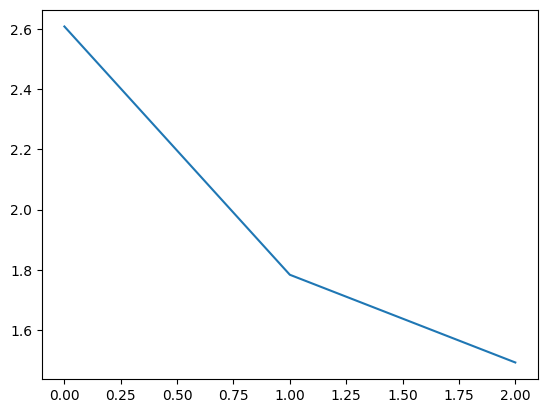

In [38]:
hidden_size = 128
batch_size = 32

input_lang,output_lang,train_loader = get_dataLoader(batch_size)
encoder = EncoderRNN(input_lang.n_words,hidden_size,hidden_size).to(device)
decoder = AttentionDecoderRNN(hidden_size,hidden_size,output_lang.n_words).to(device)

train(train_loader,encoder,decoder,n_epoch=3,print_every=1,plot_evey=1)


encoder.eval()
decoder.eval()
evaluateRandomly(encoder,decoder)


# 可视化注意力

In [ ]:
import matplotlib.ticker as ticker

def showAttention(input_sentence,output_words,attentions):
    fig,ax = plt.subplots()

    ax = plt.gca()
    cax = ax.matshow(attentions.cpu().numpy(),cmap=plt.cm.Blues)

    fig.colorbar(cax)

    input_word = input_sentence.split(' ')+['<eos>']
    ax.set_xticks(range(len(input_word)))
    ax.set_yticks(range(len(output_words)))
    ax.set_xticklabels(input_word,rotation = 90)
    ax.set_yticklabels(output_words)


    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))


# 
def evaluteAndShowAttention(input_sentence):
    output_words,attentions = evaluate(encoder,decoder,input_sentence,input_lang,output_lang)
    print('input = ',input_sentence)
    print('output = ',output_words)
    showAttention(input_sentence,output_words,attentions[0,:len(output_words),:])
    
 